In [ ]:
# grant access to the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Datasets/

Mounted at /content/drive
/content/drive/MyDrive/Datasets


In [ ]:
# import librairies and set random seed for reproductibility

In [ ]:
import numpy as np
import tensorflow as tf

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

import os
import cv2
import random

from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
# make sure using full computational capability

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print(100*"#")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Oct 11 15:42:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# functions to load and preprocess images and labels

In [ ]:
def load_images_and_labels(categories, im_ = 1):
    img_lst=[]
    labels=[]
    for category in tqdm(categories):
        folder = os.listdir(path+"/"+category)
        random.seed(20)                        # shuffle because they are organized as coming from list_dir function
        folder = random.choices(folder, k = im_) # here limites the number of images per categories
        for image_name in folder:
            img = cv2.imread(path+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # keeps RGB columns
            img = cv2.resize(img,(224, 224), interpolation=cv2.INTER_AREA)  # resize image to 224 x 224 because the input image resolution for AlexNet is 227 x 227
            img_array = Image.fromarray(img, 'RGB')        #.  'RGB' / 'L'   for color or grey scale
            img_lst.append(np.array(img_array))
            labels.append(category[10:])
    print("images loaded")
    return img_lst, labels

In [ ]:
def apply_transfo(images, labels, n_transfo=3, keep_original=False):
    img_lst=[]
    _labels = []
    print("expected iterations: ", len(images))
    for idx, image in tqdm(enumerate(images)):
        if keep_original:
            img_lst.append(image)
            _labels.append(labels[idx])
        for i in range(n_transfo):             # apply n random transformations
            augmented_img = datagen.random_transform(image)
            img_lst.append(np.array(augmented_img))
            _labels.append(labels[idx])
    print("images transformed")
    return img_lst, _labels

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,      # Random rotation (up to 20 degrees)
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest',     # Fill mode for newly created pixels
    data_format='channels_last'
)

In [ ]:
def normalize_(images,labels):
  images = np.array(images)
  labels = np.array(labels)
  #print("\n==> Necessary to normalize images' pixels")
  images = images.astype(np.float32)                      #### not necessary if using image transfo function ?!?
  images = images/255
  #print("\n\n*** images format after normalisation ***\n\n",images[1][:2])
  print("\nShapes:\nImages shape ",images.shape,"Labels shape = ",labels.shape)
  return (images,labels)

In [ ]:
#load data and transform normalize
path = "Images"
categories = os.listdir(path)

img_lst, labels = load_images_and_labels(categories, im_=210)
images, labels = apply_transfo(img_lst, labels, n_transfo = 3, keep_original=False)
images, labels = normalize_(images,labels)

100%|██████████| 10/10 [00:59<00:00,  5.91s/it]


images loaded
expected iterations:  2100


2100it [00:55, 37.91it/s]


images transformed

Shapes:
Images shape  (6300, 224, 224, 3) Labels shape =  (6300,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
enc_label = label_enc.fit_transform(labels)

# split to learn model
x_train, x_test, y_train, y_test = train_test_split(images, enc_label, train_size = 0.8, random_state = 42, stratify=labels)

x_train = x_train.astype('float32')
y_train = y_train.astype('int32')
x_test = x_test.astype('float32')
y_test = y_test.astype('int32')



In [ ]:
# build model and look for best hyperparameters

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Flatten, Dropout
from keras import Model, regularizers
# Charger modèle pré-entraîné sur ImageNet et sans les couches fully-connected
def model_builder(hp):
    _model = InceptionV3( input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    # Définir les paramètres à optimiser
    hp_units1 = hp.Int('units1', min_value=128, max_value=512, step=256)
    hp_units2 = hp.Int('units2', min_value=128, max_value=512, step=256)
    hp_dense1_l1 = hp.Choice('dense1_l1', values=[1e-3,1e-4,1e-5])
    hp_dense1_l2 = hp.Choice('dense1_l2', values=[1e-3,1e-4,1e-5])
    hp_dropout_1 = hp.Choice('dropout1', values=[0.0, 1e-1, 2e-1])
    hp_dense2_l1 = hp.Choice('dense2_l1', values=[1e-3,1e-4,1e-5])
    hp_dense2_l2 = hp.Choice('dense2_l2', values=[1e-3,1e-4,1e-5])
    hp_dropout_2 = hp.Choice('dropout2', values=[0.0, 1e-1, 2e-1])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    # Récupérer la sortie de ce réseau
    x = _model.output
    x = Flatten(name="flatten")(x)
    x = Dense(units=hp_units1, activation='relu',
              kernel_regularizer=regularizers.L1L2(l1=hp_dense1_l1, l2=hp_dense1_l2),
              kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dropout(hp_dropout_1)(x)
    x = Dense(units=hp_units2, activation='relu',
              kernel_regularizer=regularizers.L1L2(l1=hp_dense2_l1, l2=hp_dense2_l2))(x)
    x = Dropout(hp_dropout_2)(x)
    # Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
    x = Dense(10, activation='softmax')(x)
    # Définir le nouveau modèle
    _model = Model(inputs=_model.input, outputs=x)

    for layer in _model.layers[0:-5]:
        layer.trainable = False

    _model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return _model

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 44.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import keras
from tensorflow.keras.layers import Dropout

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=1,
                     factor=2,
                     directory='tuning_dogs',
                     project_name='first_trial',
                     overwrite = True)                                            # to remove if want to keep saved searches

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=2)

tuner.search(x_train, y_train, epochs=1,
             validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer 1 and 2 are {best_hps.get('units1'),best_hps.get('units2')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the best dropout ratio for each dense layer is {best_hps.get('dropout1'),best_hps.get('dropout2')}
and the best regularisation are {best_hps.get('dense1_l1'),best_hps.get('dense1_l2')} for layer 1 and {best_hps.get('dense2_l1'),best_hps.get('dense2_l2')} for layer 2.
""")

Trial 1 Complete [00h 00m 37s]
val_accuracy: 0.8829365372657776

Best val_accuracy So Far: 0.8829365372657776
Total elapsed time: 00h 00m 37s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer 1 and 2 are (384, 128), the optimal learning rate for the optimizer
is 0.001 and the best dropout ratio for each dense layer is (0.0, 0.2)
and the best regularisation are (0.0001, 1e-05) for layer 1 and (0.0001, 1e-05) for layer 2.



In [ ]:
# train and evaluate best model

In [ ]:
import keras
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor='val_loss', patience=3)

model = tuner.hypermodel.build(best_hps)#(x)
model_info = model.fit(x_train, y_train, batch_size=64, epochs=6, validation_split=0.3, callbacks=[stop_early])


Epoch 1/6
56/56 [==============================] - 23s 287ms/step - loss: 12.5035 - accuracy: 0.7455 - val_loss: 8.6189 - val_accuracy: 0.8519
Epoch 2/6
56/56 [==============================] - 10s 181ms/step - loss: 6.8077 - accuracy: 0.8557 - val_loss: 5.2156 - val_accuracy: 0.8684
Epoch 3/6
56/56 [==============================] - 10s 185ms/step - loss: 4.2774 - accuracy: 0.8801 - val_loss: 3.5915 - val_accuracy: 0.8902
Epoch 4/6
56/56 [==============================] - 10s 188ms/step - loss: 3.9600 - accuracy: 0.8313 - val_loss: 3.2750 - val_accuracy: 0.9015
Epoch 5/6
56/56 [==============================] - 11s 194ms/step - loss: 2.8090 - accuracy: 0.8985 - val_loss: 2.6101 - val_accuracy: 0.8763
Epoch 6/6
56/56 [==============================] - 11s 198ms/step - loss: 2.3259 - accuracy: 0.9147 - val_loss: 2.4931 - val_accuracy: 0.8836


40/40 [==============================] - 5s 100ms/step


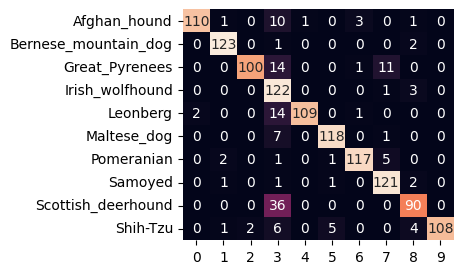

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       126
           1       0.96      0.98      0.97       126
           2       0.98      0.79      0.88       126
           3       0.58      0.97      0.72       126
           4       0.99      0.87      0.92       126
           5       0.94      0.94      0.94       126
           6       0.96      0.93      0.94       126
           7       0.87      0.96      0.91       126
           8       0.88      0.71      0.79       126
           9       1.00      0.86      0.92       126

    accuracy                           0.89      1260
   macro avg       0.91      0.89      0.89      1260
weighted avg       0.91      0.89      0.89      1260



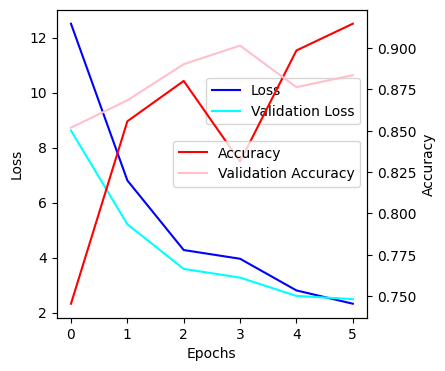

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
c = confusion_matrix(y_test,np.argmax(pred, axis=1))

# **************************************************

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.heatmap(c, ax=ax, yticklabels=label_enc.inverse_transform(np.arange(10)), annot=True, fmt='.0f', cbar=False)
#ax.set_xticklabels(labels_, rotation=45, ha='right')
plt.show()

# **************************************************

from sklearn.metrics import classification_report
print(classification_report(y_test,np.argmax(pred, axis=1)))

# **************************************************

plt.figure(figsize=(4,4))
plt.plot(model_info.history['loss'], color='blue', label='Loss')
plt.plot(model_info.history['val_loss'], color='cyan', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.8))

ax2 = plt.twinx()
plt.plot(model_info.history['accuracy'], color='red', label='Accuracy')
plt.plot(model_info.history['val_accuracy'], color='pink', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.show()

In [ ]:
# save model

In [ ]:
import pickle


!mkdir -p saved_models/inception
#pickle.dump(labels, open('breed_names.save', 'wb'))
model.save('saved_models/inception/model_inception_final_.keras', overwrite=True, save_format="keras")
#model.save_weights('model_vgg16_tuned_weight.keras',overwrite=True


# my_model directory
%ls saved_models

# Contains an assets folder, saved_model.pb, and variables folder.
%ls saved_models/inception

inception/  vgg16/
model_inception_final.keras  model_inception_final_.keras


In [ ]:
%ls

breed_names.save
Images/
label_encoder
model_inceptionV3_fine_tuned_210pic_3transf.keras
model_vgg16_fine_tuned_10cat_210img_tuned.keras
saved_models/
tuning_dogs/


In [ ]:
# make sure model is saved and accurate

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
# check that model is really saved

new_model = tf.keras.models.load_model('saved_models/inception/model_inception_final.keras')

# Check its architecture
#new_model.summary()


In [ ]:
loss, acc = new_model.evaluate(images, enc_label)#, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

197/197 [==============================] - 18s 79ms/step - loss: 12.0829 - accuracy: 0.9706
Restored model, accuracy: 97.06%
